# DATA 605 Big Data System Final Project
## Covid Group
### Group Members: David Chan, Anqi Cheng, Jing Du, Vadim Korotkikh, Heeya Trisal, Lingxuan Yang

Big Data is data that is so massive that it can’t be housed in a traditional database system or analyzed using conventional data processing techniques. COVID has the characteristics of big data because it is a global pandemic and currently ongoing, meaning new data is being produced everyday and added to the ever growing database tracking COVID cases. 

Our project looks for a relationship between vaccination and COVID infection and mortality rates and to use Big Data Systems and Big Data tools (Dask) to analyze the relationship and find the magnitude of the impact that vaccinations are having on the COVID pandemic as it is ongoing. For analysis we used machine learning libraries in Dask to make predictions. Our model looks at United State's Covid Data and Vaccine data in each state, and we are trying to see if we can predict future covid case number in each state based on our current vaccine and covide data. 


In [1]:
import dask, csv
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron

import matplotlib.pyplot as plt
from ipywidgets import *
import datetime

import pandas as pd
import numpy as np

#testing
import doctest
import unittest

#prefs
pd.set_option('max_columns', None)


## Dask

Our team decided to use Dask because we had a massive amount of data and Dask is well known for operationalizing large data well. Furthermore, the task at hand for this project was to create a big data system which involves real time data. Dask is able to provide this real time feedback and diagnostics. The major issue we knew that we would run into using such a large data was long training time and Dask is also able to resolve this through Dask-ML. Dask-ML deploys XGBoost or Tensorflow alongside Dask, and hands the data over. Replacing NumPy arrays with Dask arrays makes scaling algorithms easier because Dask arrays cut up the large array into many small arrays. 

Dask offers in-memory computing, data locality, and lazy evaluation, which is common for Big Data engines. Dask provides almost transparent parallelization of applications manipulating NumPy arrays or Pandas data frames. In our project, we used Dask 2021.4.1, dask-ml 1.9.0.

### Create Dask Client

In [2]:
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)

name 'client' is not defined


In [3]:
#get new connection
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

<Client: 'tcp://127.0.0.1:51284' processes=2 threads=4, memory=14.90 GiB>

### Create Load Data File Testing Function

In [4]:
def daskload_datafile(filepath):
    """ Loads a datafile containing COVID data into a dask dataframe.
        Sets the date to be datetime format.
        :param filepath: str
        :return: dask.dataframe.core.DataFrame
        >>> type(daskload_datafile("./us_state_vaccinations.csv"))
        <class 'dask.dataframe.core.DataFrame'>
    """
    covid_data = None
    try:
        covid_data = dd.read_csv(filepath)
        if 'date' in covid_data.columns:
            covid_data['date'] = dd.to_datetime(covid_data.date)
        elif 'submission_date' in covid_data.columns:
            covid_data['date'] = dd.to_datetime(covid_data.submission_date)
            covid_data.drop('submission_date', axis=1)
        return covid_data
    except Exception as e:       
        if str(e) == 'FileNotFoundError':
            raise(e)
        else:
            raise(e)
    


### Load Data

#### Data Set 1: United States Vaccination Data

State-by-state data on United States COVID-19 vaccination. This dataset rely on the data updated daily by the United States Centers for Disease Control and Prevention.

15 parameters are in the dataset: Location, Date, Total_vaccinations, total_vaccinations_per_hundred, daily_vaccinations_raw, daily_vaccinations, daily_vaccinations_per_million, people_vaccinated, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, total_distributed, total_distributed_per_hundred, and share_doses_used.

In [5]:
# Get vaccination data set

state_data = daskload_datafile("us_state_vaccinations.csv")
type(state_data)
if __name__ == "__main__":
    doctest.testmod(verbose=True)


Trying:
    type(daskload_datafile("./us_state_vaccinations.csv"))
Expecting:
    <class 'dask.dataframe.core.DataFrame'>
ok
1 items had no tests:
    __main__
1 items passed all tests:
   1 tests in __main__.daskload_datafile
1 tests in 2 items.
1 passed and 0 failed.
Test passed.


#### Data Set 2: United States COVID-19 Cases and Deaths by State over Time

CDC reports aggregate counts of COVID-19 cases and death numbers daily online. 

Data on the COVID-19 website and CDC’s COVID DATA Tracker are based on these most recent numbers reported by states, territories, and other jurisdictions.

There are 14 parameters in this dataset: Date, State, tot_cases, conf_cases, prob_cases, new_case, pnew_case, tot_death, conf_death, prob_death, new_death, pnew_death, consent_cases, and consent_death. 


In [6]:
gd_sdata = daskload_datafile("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_May8cleaned.csv")

gd_sdata = gd_sdata[['date','state']+[c for c in gd_sdata if c not in ['date','state']]]
gd_sdata = gd_sdata.sort_values('date').reset_index()
gd_sdata = gd_sdata.drop('index', axis=1)
gd_sdata = gd_sdata.drop('created_at', axis=1)

### Join Data Tables & Create New Columns

In [7]:
# Merge two data tables and go for correlation analysis between vaccination and deaths
joined = dd.merge(state_data, gd_sdata,  how='inner', left_on=['date','location'], right_on = ['date','state'])
joined = joined.drop('location', axis=1)
joined = joined.drop('consent_cases', axis=1)
joined = joined.drop('consent_deaths', axis=1)
joined.shape[0].compute()
joined.head()

date  total_vaccinations  total_distributed  people_vaccinated  \
0 2021-01-12             78134.0           377025.0            70861.0   
1 2021-01-13             84040.0           378975.0            74792.0   
2 2021-01-14             92300.0           435350.0            80480.0   
3 2021-01-15            100567.0           444650.0            86956.0   
4 2021-01-16                 NaN                NaN                NaN   

   people_fully_vaccinated_per_hundred  total_vaccinations_per_hundred  \
0                                 0.15                            1.59   
1                                 0.19                            1.71   
2                                  NaN                            1.88   
3                                 0.28                            2.05   
4                                  NaN                             NaN   

   people_fully_vaccinated  people_vaccinated_per_hundred  \
0                   7270.0                           1.45   
1                   9245.0                           1.53   
2                      NaN                           1.64   
3                  13488.0                           1.77   
4                      NaN                            NaN   

   distributed_per_hundred  daily_vaccinations_raw  daily_vaccinations  \
0                     7.69                     NaN                 NaN   
1                     7.73                  5906.0              5906.0   
2                     8.88                  8260.0              7083.0   
3                     9.07                  8267.0              7478.0   
4                      NaN                  7557.0              7498.0   

   daily_vaccinations_per_million  share_doses_used    state submission_date  \
0                             NaN             0.207  Alabama      01/12/2021   
1                          1205.0             0.222  Alabama      01/13/2021   
2                          1445.0             0.212  Alabama      01/14/2021   
3                          1525.0             0.226  Alabama      01/15/2021   
4                          1529.0               NaN  Alabama      01/16/2021   

   tot_cases  conf_cases  prob_cases  new_case  pnew_case  tot_death  \
0     428288      337826       90462      3417        796       8071   
1     431512      340154       91358      3224        896       8154   
2     434722      342467       92255      3210        897       8248   
3     437722      344636       93086      3000        831       8321   
4     439566      345988       93578      1844        492       8390   

   conf_death  prob_death  new_death  pnew_death  
0        6491        1580         77          14  
1        6546        1608         83          28  
2        6613        1635         94          27  
3        6664        1657         73          22  
4        6715        1675         69          18

In [8]:
joined["nextDay"] = joined.date + np.timedelta64(14,'D')
joined.head()
#dep = new cases in the future
#independent(the day of )
#regression feed in your dataframe with time and values, 
#regression -> predict(independent variables) 

date  total_vaccinations  total_distributed  people_vaccinated  \
0 2021-01-12             78134.0           377025.0            70861.0   
1 2021-01-13             84040.0           378975.0            74792.0   
2 2021-01-14             92300.0           435350.0            80480.0   
3 2021-01-15            100567.0           444650.0            86956.0   
4 2021-01-16                 NaN                NaN                NaN   

   people_fully_vaccinated_per_hundred  total_vaccinations_per_hundred  \
0                                 0.15                            1.59   
1                                 0.19                            1.71   
2                                  NaN                            1.88   
3                                 0.28                            2.05   
4                                  NaN                             NaN   

   people_fully_vaccinated  people_vaccinated_per_hundred  \
0                   7270.0                           1.45   
1                   9245.0                           1.53   
2                      NaN                           1.64   
3                  13488.0                           1.77   
4                      NaN                            NaN   

   distributed_per_hundred  daily_vaccinations_raw  daily_vaccinations  \
0                     7.69                     NaN                 NaN   
1                     7.73                  5906.0              5906.0   
2                     8.88                  8260.0              7083.0   
3                     9.07                  8267.0              7478.0   
4                      NaN                  7557.0              7498.0   

   daily_vaccinations_per_million  share_doses_used    state submission_date  \
0                             NaN             0.207  Alabama      01/12/2021   
1                          1205.0             0.222  Alabama      01/13/2021   
2                          1445.0             0.212  Alabama      01/14/2021   
3                          1525.0             0.226  Alabama      01/15/2021   
4                          1529.0               NaN  Alabama      01/16/2021   

   tot_cases  conf_cases  prob_cases  new_case  pnew_case  tot_death  \
0     428288      337826       90462      3417        796       8071   
1     431512      340154       91358      3224        896       8154   
2     434722      342467       92255      3210        897       8248   
3     437722      344636       93086      3000        831       8321   
4     439566      345988       93578      1844        492       8390   

   conf_death  prob_death  new_death  pnew_death    nextDay  
0        6491        1580         77          14 2021-01-26  
1        6546        1608         83          28 2021-01-27  
2        6613        1635         94          27 2021-01-28  
3        6664        1657         73          22 2021-01-29  
4        6715        1675         69          18 2021-01-30

In [9]:
nextdate = dd.merge(joined, joined,  how='inner', left_on=['date','state'], right_on = ['nextDay','state'])
nextdate.tail()
nextdate.persist()

Dask DataFrame Structure:
                       date_x total_vaccinations_x total_distributed_x people_vaccinated_x people_fully_vaccinated_per_hundred_x total_vaccinations_per_hundred_x people_fully_vaccinated_x people_vaccinated_per_hundred_x distributed_per_hundred_x daily_vaccinations_raw_x daily_vaccinations_x daily_vaccinations_per_million_x share_doses_used_x   state submission_date_x tot_cases_x conf_cases_x prob_cases_x new_case_x pnew_case_x tot_death_x conf_death_x prob_death_x new_death_x pnew_death_x       nextDay_x          date_y total_vaccinations_y total_distributed_y people_vaccinated_y people_fully_vaccinated_per_hundred_y total_vaccinations_per_hundred_y people_fully_vaccinated_y people_vaccinated_per_hundred_y distributed_per_hundred_y daily_vaccinations_raw_y daily_vaccinations_y daily_vaccinations_per_million_y share_doses_used_y submission_date_y tot_cases_y conf_cases_y prob_cases_y new_case_y pnew_case_y tot_death_y conf_death_y prob_death_y new_death_y pnew_death_y       nextDay_y
npartitions=1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
               datetime64[ns]              float64             float64             float64                               float64                          float64                   float64                         float64                   float64                  float64              float64                          float64            float64  object            object       int64        int64        int64      int64       int64       int64        int64        int64       int64        int64  datetime64[ns]  datetime64[ns]              float64             float64             float64                               float64                          float64                   float64                         float64                   float64                  float64              float64                          float64            float64            object       int64        int64        int64      int64       int64       int64        int64        int64       int64        int64  datetime64[ns]
                          ...                  ...                 ...                 ...                                   ...                              ...                       ...                             ...                       ...                      ...                  ...                              ...                ...     ...               ...         ...          ...          ...        ...         ...         ...          ...          ...         ...          ...             ...             ...                  ...                 ...                 ...                                   ...                              ...                       ...                             ...                       ...                      ...                  ...                              ...                ...               ...         ...          ...          ...        ...         ...         ...          ...          ...         ...          ..

In [10]:
#new case for the next day would be "new_case_x"
#today's data would be "column_name_y"
nextdate['nextday_new_case'] = nextdate.new_case_x
nextdate["new_people_fully_vaccinated"] = nextdate.people_fully_vaccinated_x - nextdate.people_fully_vaccinated_y
nextdate["new_people_vaccinated"] = nextdate.people_vaccinated_x - nextdate.people_vaccinated_y
nextdate.head()

date_x  total_vaccinations_x  total_distributed_x  people_vaccinated_x  \
0 2021-01-26              254959.0             569000.0             223854.0   
1 2021-01-27              266444.0             634000.0             232633.0   
2 2021-01-28              278993.0             655275.0             241337.0   
3 2021-01-29              300915.0             659400.0             256601.0   
4 2021-01-30              342436.0             659400.0             288368.0   

   people_fully_vaccinated_per_hundred_x  total_vaccinations_per_hundred_x  \
0                                   0.63                              5.20   
1                                   0.69                              5.43   
2                                   0.76                              5.69   
3                                   0.90                              6.14   
4                                   1.10                              6.98   

   people_fully_vaccinated_x  people_vaccinated_per_hundred_x  \
0                    30933.0                             4.57   
1                    33595.0                             4.74   
2                    37431.0                             4.92   
3                    44073.0                             5.23   
4                    53742.0                             5.88   

   distributed_per_hundred_x  daily_vaccinations_raw_x  daily_vaccinations_x  \
0                      11.60                    4347.0               17738.0   
1                      12.93                   11485.0               18178.0   
2                      13.36                   12549.0               16153.0   
3                      13.45                   21922.0               14514.0   
4                      13.45                   41521.0               17271.0   

   daily_vaccinations_per_million_x  share_doses_used_x    state  \
0                            3618.0               0.448  Alabama   
1                            3707.0               0.420  Alabama   
2                            3294.0               0.426  Alabama   
3                            2960.0               0.456  Alabama   
4                            3522.0               0.519  Alabama   

  submission_date_x  tot_cases_x  conf_cases_x  prob_cases_x  new_case_x  \
0        01/26/2021       465648        364332        101316        2850   
1        01/27/2021       468140        366063        102077        2492   
2        01/28/2021       470399        367619        102780        2259   
3        01/29/2021       472330        368988        103342        1931   
4        01/30/2021       473545        369874        103671        1215   

   pnew_case_x  tot_death_x  conf_death_x  prob_death_x  new_death_x  \
0          889         9154          7263          1891           73   
1          761         9214          7303          1911           60   
2          703         9294          7359          1935           80   
3          562         9370          7416          1954           76   
4          329         9436          7458          1978           66   

   pnew_death_x  nextDay_x     date_y  total_vaccinations_y  \
0            17 2021-02-09 2021-01-12               78134.0   
1            20 2021-02-10 2021-01-13               84040.0   
2            24 2021-02-11 2021-01-14               92300.0   
3            19 2021-02-12 2021-01-15              100567.0   
4            24 2021-02-13 2021-01-16                   NaN   

   total_distributed_y  people_vaccinated_y  \
0             377025.0              70861.0   
1             378975.0              74792.0   
2             435350.0              80480.0   
3             444650.0              86956.0   
4                  NaN                  NaN   

   people_fully_vaccinated_per_hundred_y  total_vaccinations_per_hundred_y  \
0                                   0.15                              1.59   
1                                   0.19                           

### Data Cleaning

In [11]:
p =nextdate[~nextdate.isin([np.nan, np.inf, -np.inf]).any(1)]

# Lose a lot of good data due to NaNs, or basically blanks even though there's people vaccinated per hundred at etc.
display(len(p))
p.tail()

5305

date_x  total_vaccinations_x  total_distributed_x  \
5707 2021-05-03              358545.0             483195.0   
5708 2021-05-04              361199.0             483595.0   
5709 2021-05-05              363149.0             485195.0   
5710 2021-05-06              363390.0             486635.0   
5711 2021-05-07              367548.0             487055.0   

      people_vaccinated_x  people_fully_vaccinated_per_hundred_x  \
5707             197374.0                                  28.05   
5708             198293.0                                  28.34   
5709             198821.0                                  28.57   
5710             198930.0                                  28.61   
5711             200309.0                                  29.09   

      total_vaccinations_per_hundred_x  people_fully_vaccinated_x  \
5707                             61.95                   162356.0   
5708                             62.41                   163997.0   
5709                             62.75                   165330.0   
5710                             62.79                   165555.0   
5711                             63.51                   168356.0   

      people_vaccinated_per_hundred_x  distributed_per_hundred_x  \
5707                            34.10                      83.49   
5708                            34.26                      83.56   
5709                            34.35                      83.83   
5710                            34.37                      84.08   
5711                            34.61                      84.16   

      daily_vaccinations_raw_x  daily_vaccinations_x  \
5707                      33.0                1409.0   
5708                    2654.0                1786.0   
5709                    1950.0                2038.0   
5710                     241.0                1427.0   
5711                    4158.0                1642.0   

      daily_vaccinations_per_million_x  share_doses_used_x    state  \
5707                            2435.0               0.742  Wyoming   
5708                            3086.0               0.747  Wyoming   
5709                            3521.0               0.748  Wyoming   
5710                            2466.0               0.747  Wyoming   
5711                            2837.0               0.755  Wyoming   

     submission_date_x  tot_cases_x  conf_cases_x  prob_cases_x  new_case_x  \
5707        05/03/2021        58290         49224          9066          50   
5708        05/04/2021        58367         49276          9091          77   
5709        05/05/2021        58438         49334          9104          71   
5710        05/06/2021        58527         49396          9131          89   
5711        05/07/2021        58623         49477          9146          96   

      pnew_case_x  tot_death_x  conf_death_x  prob_death_x  new_death_x  \
5707            9          707           707             0            0   
5708           25          710           710             0            3   
5709           13          710           710             0            0   
5710           27          710           710             0            0   
5711           15          710           710             0            0   

      pnew_death_x  nextDay_x     date_y  total_vaccinations_y  \
5707             0 2021-05-17 2021-04-19              323956.0   
5708             0 2021-05-18 2021-04-20              332765.0   
5709             0 2021-05-19 2021-04-21              332929.0   
5710             0 2021-05-20 2021-04-22              337560.0   
5711             0 2021-05-21 2021-04-23              340781.0   

      total_distributed_y  people_vaccinated_y  \
5707             468615.0             186518.0   
5708             469615.0             189818.0   
5709             472315.0             189930.0   
5710             472815.0             191282.0   
5711             473415.0             192173.0   

      people_fu

### Setting X and y

After testing on different features combination, the feature that our model choose to use to predict the new case 14 days after are: people vacinnated per hundred, total cases, total deaths, total vaccinations, and state.

Our dependent variable would be the new case number 14 days after.

In [12]:
#get X and y
X = p[['people_vaccinated_per_hundred_y','tot_cases_y','tot_death_y','total_vaccinations_y','state']]
y = p[['nextday_new_case']]

newX = p[['people_vaccinated_per_hundred_x','tot_cases_x','tot_death_x','total_vaccinations_x','state']]


In [13]:
#categorize X and get dummies for its state data
X = X.categorize()
X = dd.get_dummies(X, columns=['state'])

newX = newX.categorize()
newX = dd.get_dummies(newX, columns=['state'])

### Linear Regression Model

In [14]:
from dask_ml.model_selection import train_test_split as ts

In [15]:
#Dask kfold attempt using train test split

model = LinearRegression()
scores = []
kfold = 5
testsize = 1/kfold
#print(testsize)
for x in range(kfold):
    X_train, X_test, y_train, y_test = ts(X,y,test_size=testsize,shuffle=True)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))
#del model

R² scores = [0.7396896880424499, 0.7930681738540798, 0.7595944707742948, 0.8088073772072478, 0.7644059268124929], mean = 0.7731131273381131, stdev = 0.024689994191207616


### Ridge

In [16]:
modelRidge = Ridge(alpha=0.005, tol=0.001, solver='svd') 
# ‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’
scores = []
kfoldn = 10
testsize = 1/kfoldn
for x in range(kfoldn):
    X_train, X_test, y_train, y_test = ts(X,y,test_size=testsize,shuffle=True)
    modelRidge.fit(X_train, y_train)
    score = modelRidge.score(X_test, y_test)
    scores.append(score)
    
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))
# del modelRidge

R² scores = [0.7958531074952134, 0.7438205285194501, 0.7451130097234546, 0.8331022378216748, 0.8302189363395799, 0.7507528066024768, 0.8134147726494404, 0.7375703170191006, 0.7952489823154764, 0.8072171324988375], mean = 0.7852311830984704, stdev = 0.03548385666876738


## Results

## 4Vs 

#![Dask&4V.PNG](attachment:Dask&4V.PNG)

### Volumn:
•	The 9th deadliest pandemic in the world. 

•	127 million COVID cases and 2.79 million deaths worldwide everyday.

•	New cases continue to arise everyday.

•	3.4 million doses of vaccine are given, and 1.7 million fully vaccinated each day in US. 

•	We add more servers for DASK where the sum of all servers’ memories can handle this dataset. DASK is good at handling fit when data approaches infinity. 


### Velocity:
•	500,000 new cases worldwide is the 7 day average.

•	20 million doses of vaccines are given.

•	4 million fully vaccinated each day worldwide. 

•	Fit quickly as volume approaches infinity, and more servers and distribute the computation in DASK.

With dask, we are able to add additional servers which can help to spread the load of incoming data more efficiently. Since there is an average of about 500,000 new cases and more than 3 million doses of vaccinations each day, dask helps with keeping up with this number of new cases.

### Variety:
•	Structure Data

•	Collected by CDC and other health departments through surveillance systems

    •	Disease surveillance
    
    •	Syndromic surveillance
    
    •	Case reporting
    
    •	Lab reporting
    
    •	Health care systems reporting

•	Data types/sources are changing all the time (rapidly)

    •	Avoid by going into data frame. (Fetch sources directly used and sticked into data frame).
    
    •	Data Lake(S3) in different folders.
    
•	Use data lake when having different sources and data type coming through


### Veracity:
•	Trustworthy data from national, credible public health agencies. 

•	Maintain the accuracy

    •	Using AI
    
    •	Anomaly detection
    
    •	Statistical analysis to look at parts/pieces 
    
    •	Incremental approach batch/yield

## Switch to Pandas Dataframe

In [17]:
#Pandas Kfold method
#convert X, y to pandas dataframe
xp = X.compute()
yp = y.compute()
print(type(X))
print(type(xp))
# xPersisted = X.persist()
# display(xPersisted)
# print(type(xPersisted))
# display(xPersisted.head())
# display(xPersisted.compute())

<class 'dask.dataframe.core.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [18]:
#pandas df version of Linear Regression & kfold
modelP = LinearRegression()
scores = []
predictions = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
test_splits = []
for i, (train, test) in enumerate(kfold.split(xp, yp)):
    modelP.fit(xp.iloc[train,:], yp.iloc[train,:])
    score = modelP.score(xp.iloc[test,:], yp.iloc[test,:])
#     display(yp.iloc[train,:].shape)
    # Make predictions using the testing set
    y_pred = modelP.predict(xp.iloc[test,:])
    predictions.append(y_pred)
    scores.append(score)
    test_splits.append(xp.iloc[test,:])
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))

del modelP

R² scores = [0.7598124884837477, 0.7814254987615314, 0.7476785634283303, 0.7918681744477558, 0.7335602637516729], mean = 0.7628689977746076, stdev = 0.021374701922127343


In [19]:
modelRidge = Ridge(alpha=0.005, tol=0.001, solver='svd') 
# ‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’
scores = []
kfold = KFold(n_splits=7, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(xp, yp)):
    modelRidge.fit(xp.iloc[train,:], yp.iloc[train,:])
    score = modelRidge.score(xp.iloc[test,:], yp.iloc[test,:])
    scores.append(score)
    
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))
# del modelRidge

R² scores = [0.7601216219721079, 0.7545412914926612, 0.8026919173074429, 0.7446251260797327, 0.7904121182084956, 0.7846690007077604, 0.7299204912885143], mean = 0.7667116524366735, stdev = 0.024529015666809897


In [20]:
modelPAR = PassiveAggressiveRegressor(max_iter=1000, random_state=42)
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(xp, yp)):
    a = np.ravel(yp.iloc[train,:].to_numpy())
    modelPAR.fit(xp.iloc[train,:], a)
    yb = np.ravel(yp.iloc[test,:].to_numpy())
    score = modelPAR.score(xp.iloc[test,:], yb)
    scores.append(score)
    
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))
del modelPAR

R² scores = [0.3905195334565037, 0.07230105764562478, -0.41775516238424926, -1.01970111896257, 0.3094799025663294], mean = -0.13303115753567227, stdev = 0.5252302471061676


In [21]:
modelSGD = SGDRegressor(loss='squared_loss', penalty='elasticnet', alpha=0.005, l1_ratio=0.15, fit_intercept=False, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling')
scores = []
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for (train, test) in kfold.split(xp, yp):
#     breakpoint()
    a = np.ravel(yp.iloc[train,:].to_numpy())
    modelSGD.fit(xp.iloc[train,:], a)
    b = np.ravel(yp.iloc[test,:].to_numpy())
    score = modelSGD.score(xp.iloc[test,:], b)
    scores.append(score)
    
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))

R² scores = [-2.0486411668368162e+36, -7.429949302277117e+35, -1.4198613968255485e+37, -3.9530253409388114e+35, -1.9526047571023736e+36], mean = -3.867631471303254e+36, stdev = 5.206259197508041e+36


In [22]:
import warnings
warnings.filterwarnings('ignore')

modelB = BayesianRidge(n_iter=300, tol=0.1, alpha_1=5e-05, alpha_2=5e-05)
scores = []
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(xp, yp)):
    modelB.fit(xp.iloc[train,:], yp.iloc[train,:])
    score = modelB.score(xp.iloc[test,:], yp.iloc[test,:])
    scores.append(score)
    
print("R² scores = {}, mean = {}, stdev = {}".format(scores, np.mean(scores), np.std(scores)))

R² scores = [0.5015343546038411, 0.4982085643354378, 0.5073364384341612, 0.5131734995768586, 0.4962455686752071], mean = 0.5032996851251011, stdev = 0.006206191275473923


## Calculating 1D and 14D Predicted New Case values

In [23]:
nextdatePandas = p.compute()
#get predictions
linearPredicted = model.predict(X)
len(linearPredicted)
len(nextdatePandas.new_case_x)

#now get 14 day future values from last X
linearPredicted_14 = model.predict(newX)

# linearPred_Ridge = modelRidge.predict(X)
linearPredicted_14Ridge = modelRidge.predict(newX)

### Checking state values using Dask dfs

In [24]:
# col = "state"
# statestr = "Texas"
# ddf_state = p[p[col].str.startswith(statestr)]
def get_daskdd_state(orig_dd,statestr):
    col = "state"
    ddf_state = p[p[col].str.startswith(statestr)]
    return ddf_state[['people_vaccinated_per_hundred_y','tot_cases_y','new_case_y', 'new_case_x','total_vaccinations_y','state']]
 
newddf_state = get_daskdd_state(p, "California")
# newddf_state.head(5)

In [25]:
# newddf_state.tail(5)

In [26]:
linPred14_FL = linearPredicted_14[1021:1121,:]
linPred14_CA = linearPredicted_14[512:612,:]
linPred14_TX = linearPredicted_14[4780:4880,:]
linPred14_MD = linearPredicted_14[2230:2330,:]

linPred14R_TX = linearPredicted_14Ridge[4780:4880,:]
linPred14R_MD = linearPredicted_14Ridge[2230:2330,:]
# linPred14_CA

In [27]:
added = np.insert(linearPredicted_14,0,None,axis=0)
for i in range(0,13):
    added = np.insert(added,0,None,axis=0)


## Getting New Case data from p dask.persisted df

In [28]:
nextArray = nextdatePandas.new_case_x.to_numpy()
# nextArraynew = nextdatePandas.new_case_x

## Splitting into state data from dask df

In [29]:
orig_fl_data = get_daskdd_state(p, "Florida")
orig_fl = orig_fl_data.new_case_x.compute().to_numpy()
orig_ca_data = get_daskdd_state(p, "California")
orig_ca = orig_ca_data.new_case_x.compute().to_numpy()
orig_tx_data = get_daskdd_state(p, "Texas")
orig_tx = orig_tx_data.new_case_x.compute().to_numpy()
orig_md_data = get_daskdd_state(p, "Maryland")
orig_md = orig_md_data.new_case_x.compute().to_numpy()
# orig_md

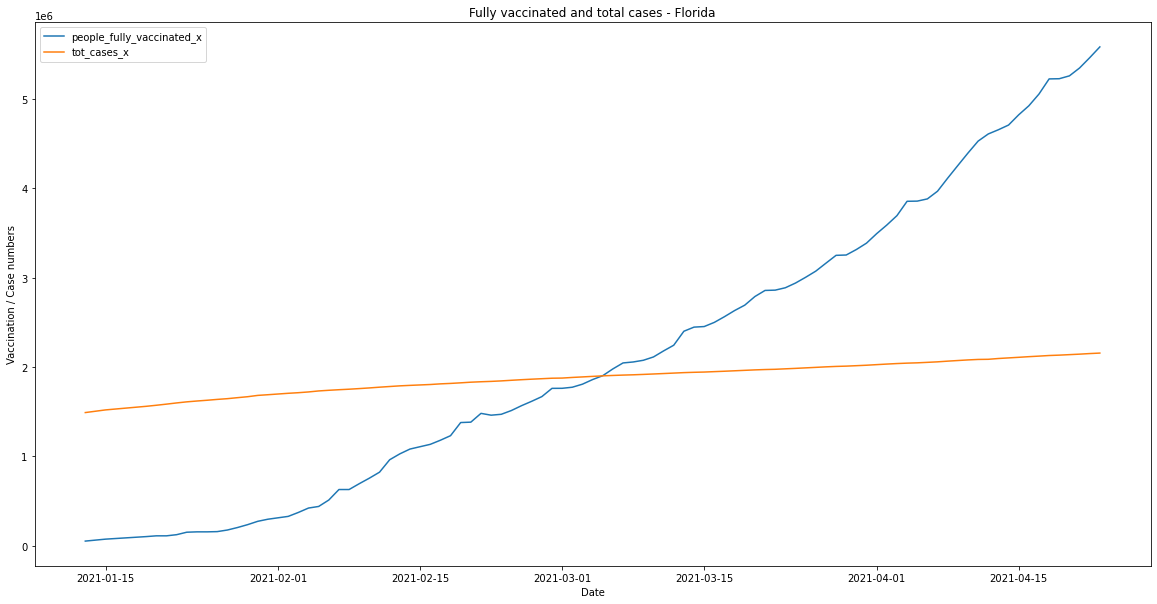

In [30]:
from pprint import pprint

def pandas_select_state(dask_df, col, statestr):
    pandas_df = dask_df.compute()
    tempdf = pandas_df[pandas_df[col].str.startswith(statestr)]
    return tempdf

pd_florida = pandas_select_state(p, 'state', 'Florida')
plt.figure(figsize=(20, 10))

xa = pd_florida.date_y
b = pd_florida.people_fully_vaccinated_y
plt.plot(xa, b, label="people_fully_vaccinated_x")
plt.plot(xa, pd_florida.tot_cases_y, label="tot_cases_x")

plt.xlabel("Date")
plt.ylabel("Vaccination / Case numbers")
plt.legend(loc="best")
plt.title("Fully vaccinated and total cases - Florida")
plt.show()

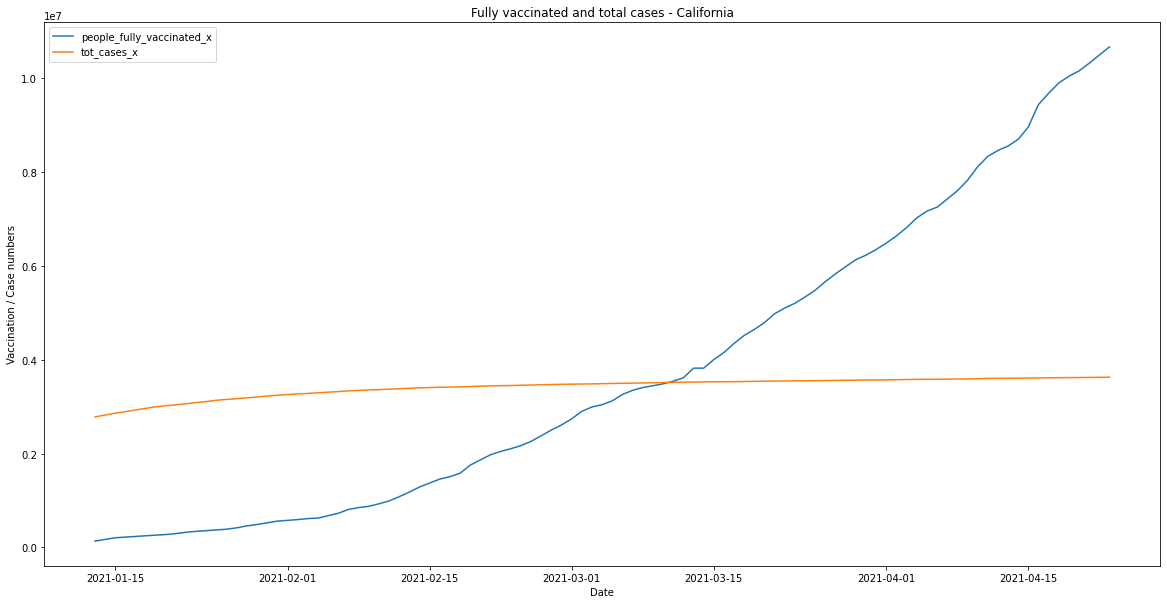

In [31]:

pd_california = pandas_select_state(p, 'state', 'California')
plt.figure(figsize=(20, 10))

xa = pd_california.date_y
b = pd_california.people_fully_vaccinated_y
plt.plot(xa, b, label="people_fully_vaccinated_x")
plt.plot(xa, pd_california.tot_cases_y, label="tot_cases_x")

plt.xlabel("Date")
plt.ylabel("Vaccination / Case numbers")
plt.legend(loc="best")
plt.title("Fully vaccinated and total cases - California")
plt.show()

<IPython.core.display.Javascript object>


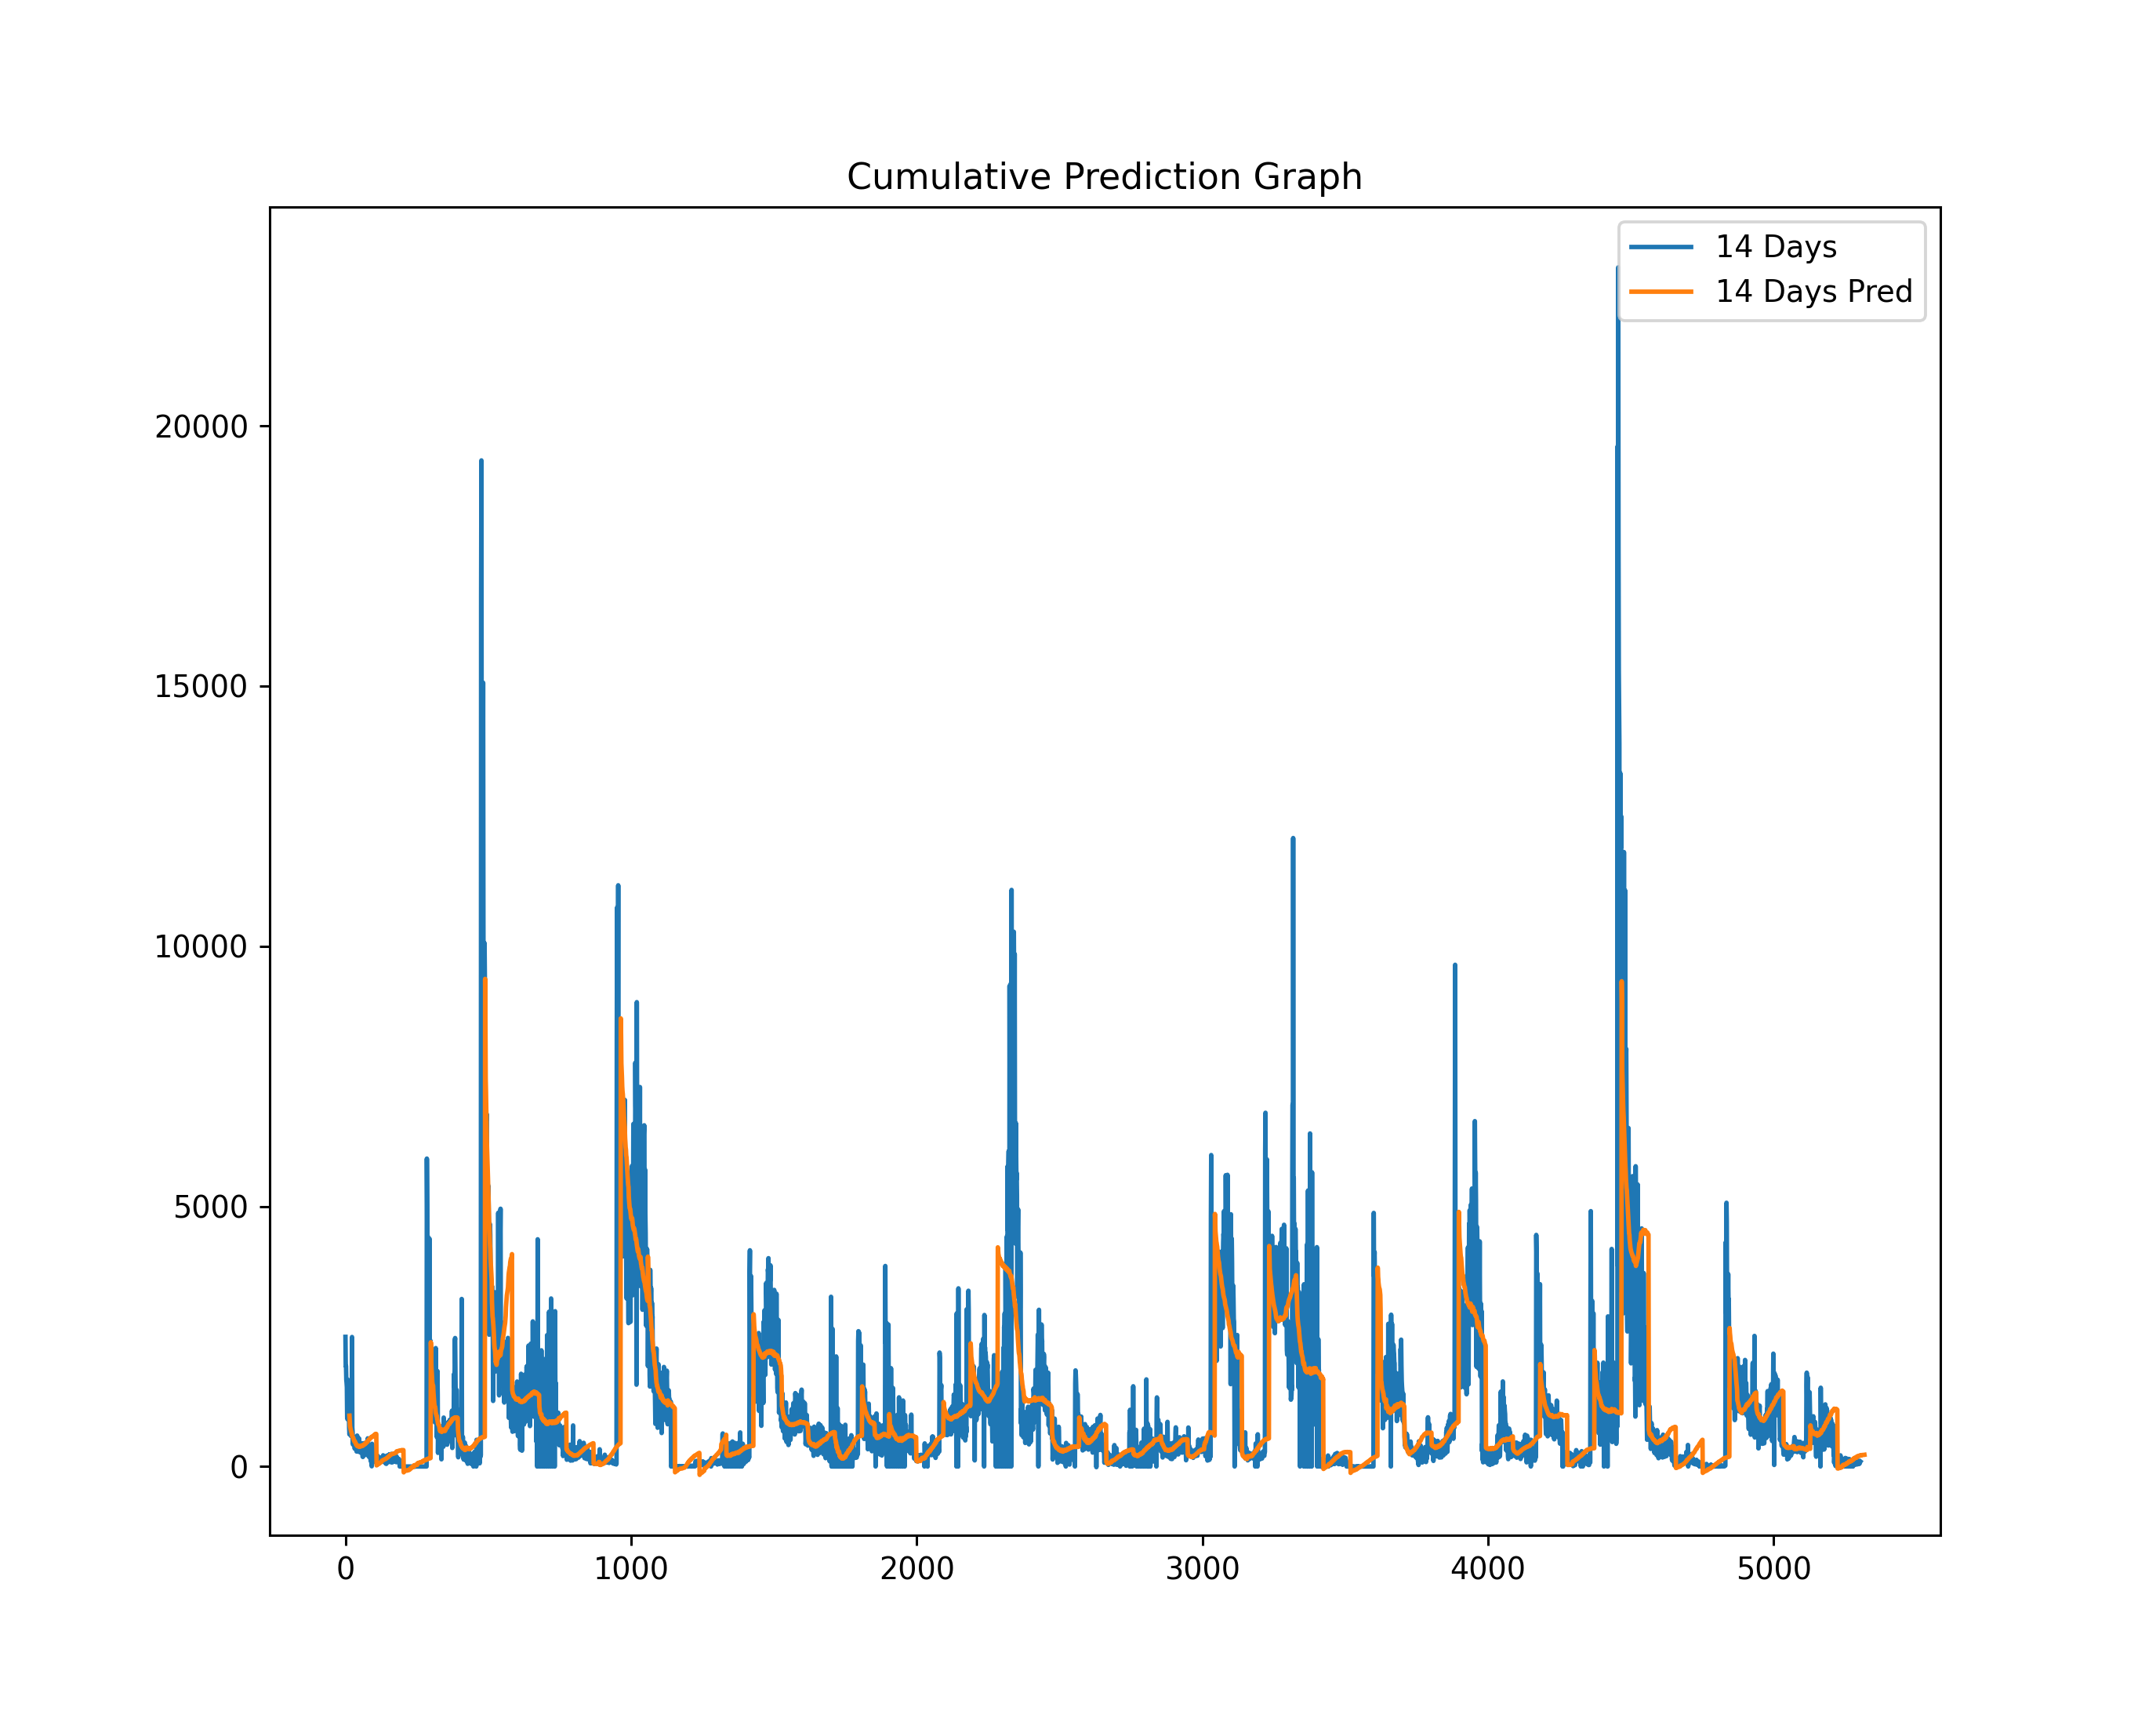

In [44]:
#!pip install ipympl
%matplotlib notebook
fig=plt.figure(figsize=(10,8), dpi= 125, facecolor='w', edgecolor='k')
# %matplotlib inline
# plt.figure(figsize=(30, 20))
#plt.plot(nextdatePandas.new_case_x,label="14Days")
plt.plot(nextArray,label="14 Days")

# added - Linear predicted 14 days using full data
plt.plot(added, label = "14 Days Pred")
plt.title("Cumulative Prediction Graph")
plt.legend()

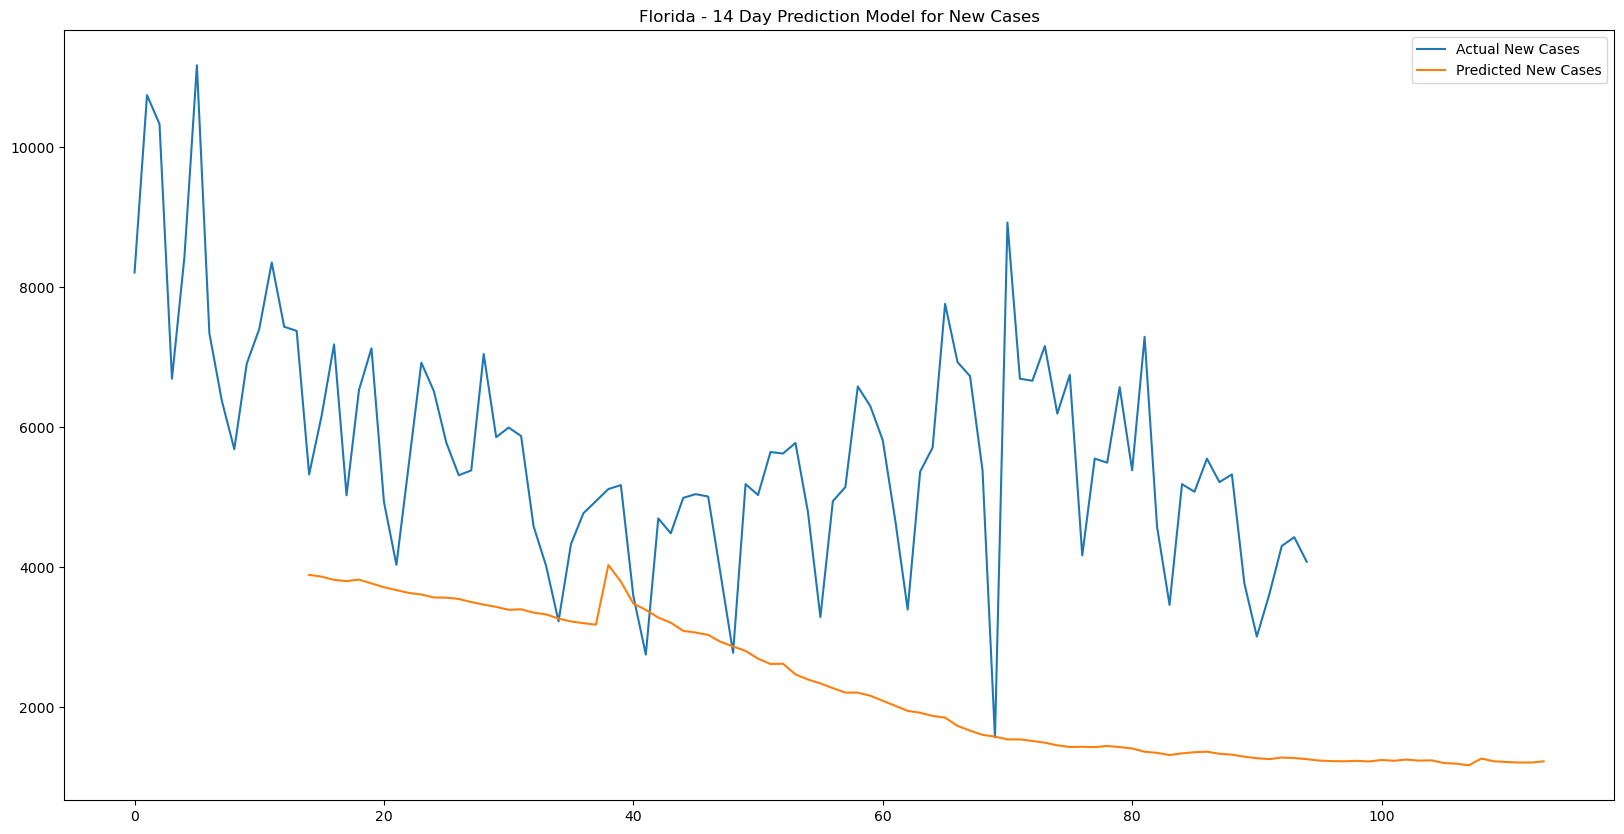

In [33]:
%matplotlib inline
addedFl = np.insert(linPred14_FL,0,None,axis=0)
for i in range(0,13):
    addedFl = np.insert(addedFl,0,None,axis=0)
# addedFl = np.insert(addedFl,0,None,axis=0)
plt.figure(figsize=(20, 10))
plt.plot(orig_fl,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedFl, label = "Predicted New Cases")
plt.title("Florida - 14 Day Prediction Model for New Cases")
plt.legend()

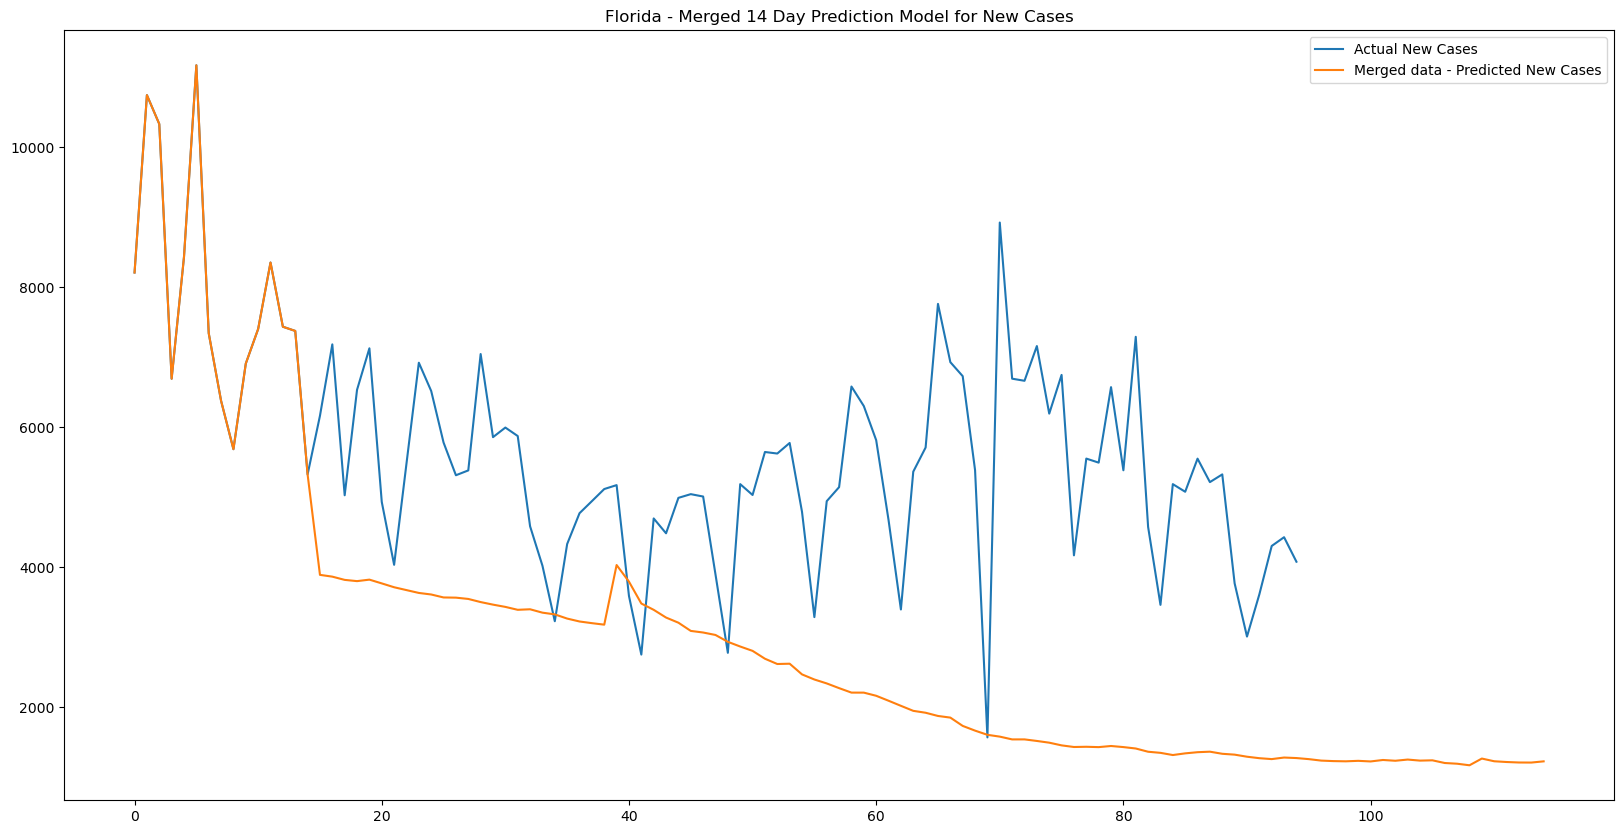

In [34]:
addedFl = np.insert(linPred14_FL,0,orig_fl[14],axis=0)
for i in range(0,13):
    addedFl = np.insert(addedFl,0,orig_fl[13-i],axis=0)
addedFl = np.insert(addedFl,0,orig_fl[0],axis=0)
plt.figure(figsize=(20, 10))
plt.plot(orig_fl,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedFl, label = "Merged data - Predicted New Cases")
plt.title("Florida - Merged 14 Day Prediction Model for New Cases")
plt.legend()

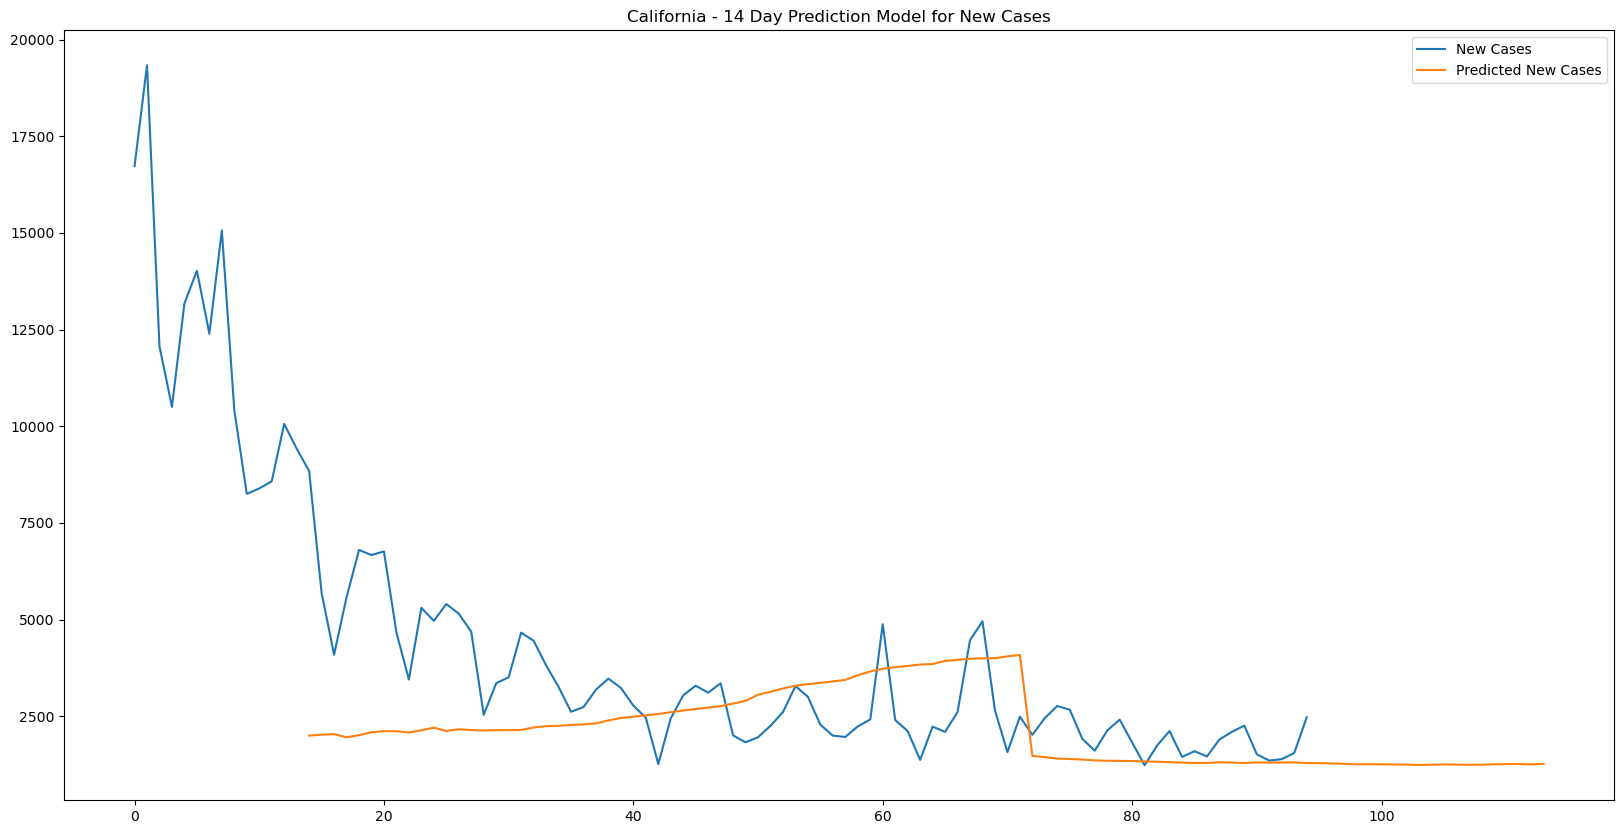

In [35]:
addedCA = np.insert(linPred14_CA,0,None,axis=0)
for i in range(0,13):
    addedCA = np.insert(addedCA,0,None,axis=0)    
plt.figure(figsize=(20, 10))
plt.plot(orig_ca,label="New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedCA, label = "Predicted New Cases")
plt.title("California - 14 Day Prediction Model for New Cases")
plt.legend()

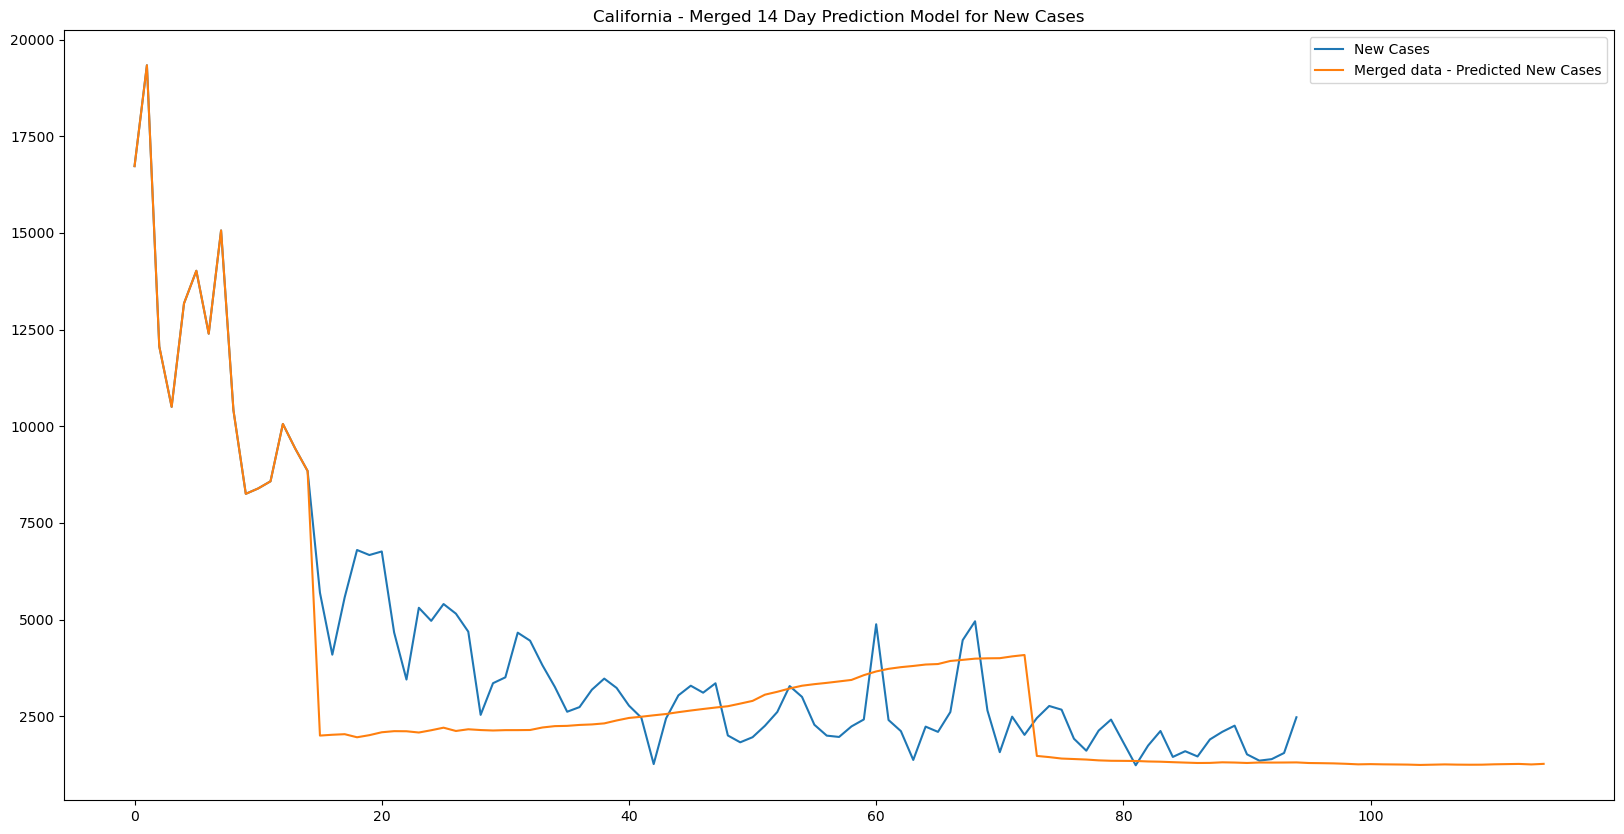

In [36]:
addedCA = np.insert(linPred14_CA,0,orig_ca[14],axis=0)
for i in range(0,13):
    addedCA = np.insert(addedCA,0,orig_ca[13-i],axis=0)
addedCA = np.insert(addedCA,0,orig_ca[0],axis=0)    
plt.figure(figsize=(20, 10))
plt.plot(orig_ca,label="New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedCA, label = "Merged data - Predicted New Cases")
plt.title("California - Merged 14 Day Prediction Model for New Cases")
plt.legend()

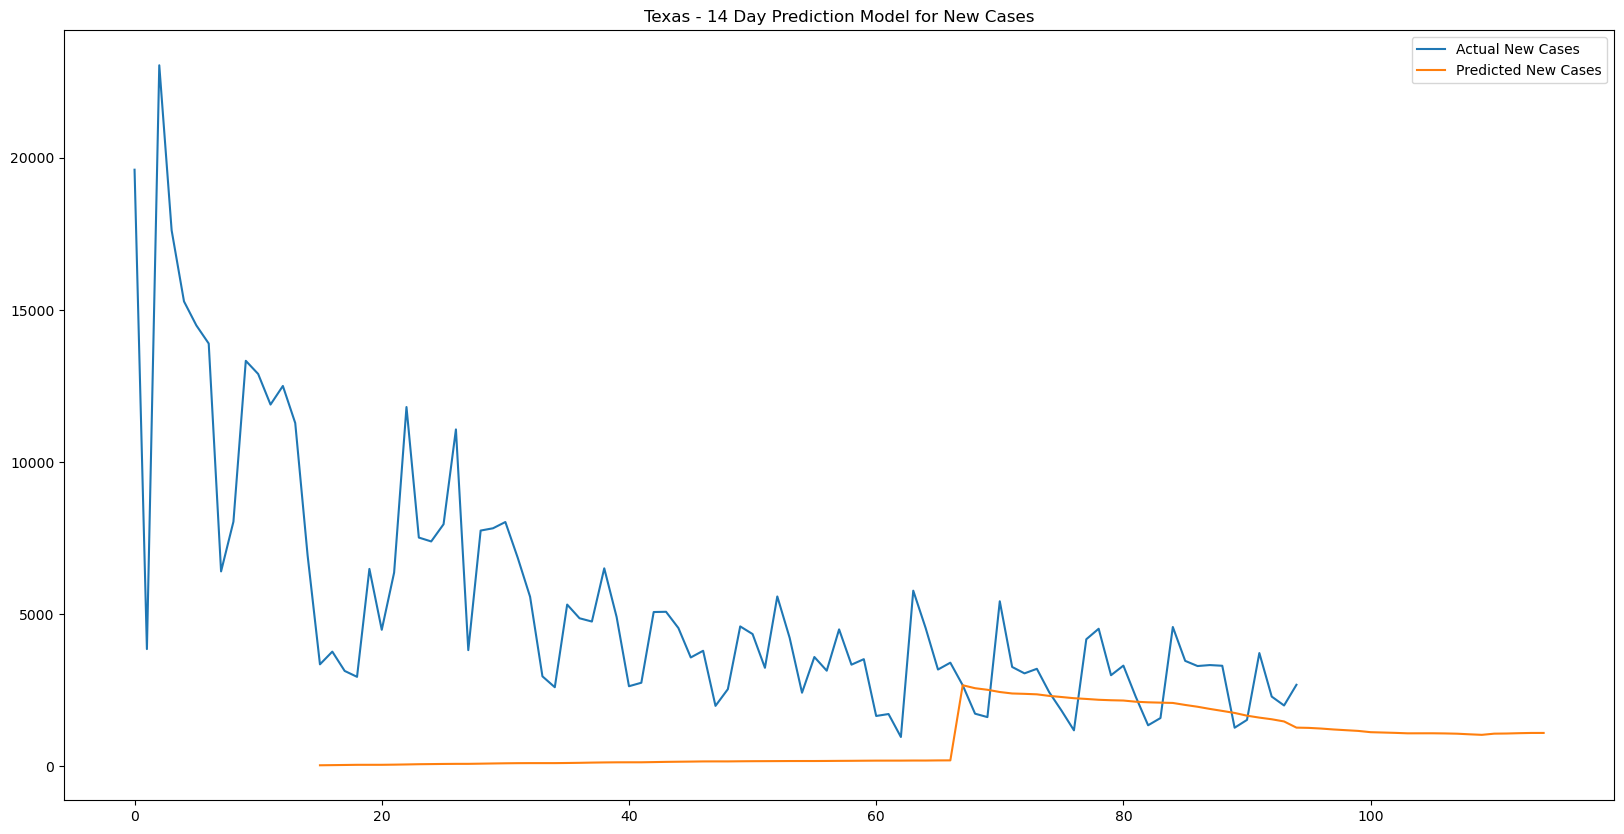

In [37]:
addedTX = np.insert(linPred14_TX,0,None,axis=0)
for i in range(0,13):
    addedTX = np.insert(addedTX,0,None,axis=0)
addedTX = np.insert(addedTX,0,None,axis=0)   
plt.figure(figsize=(20, 10))
plt.plot(orig_tx,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedTX, label = "Predicted New Cases")
plt.title("Texas - 14 Day Prediction Model for New Cases")
plt.legend()

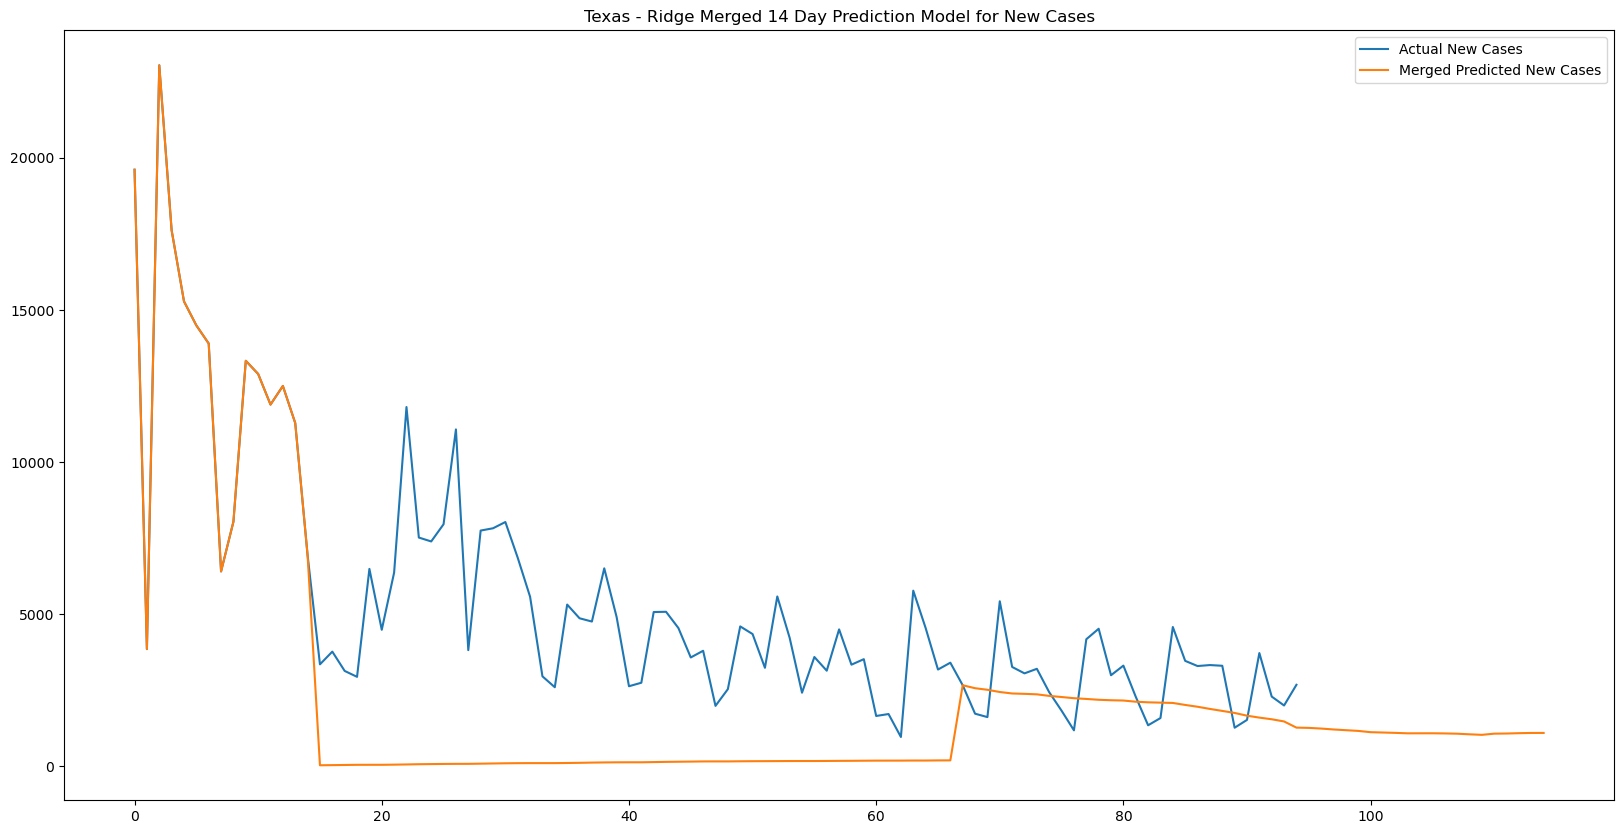

In [38]:
addedTX = np.insert(linPred14_TX,0,orig_tx[14],axis=0)
for i in range(0,13):
    addedTX = np.insert(addedTX,0,orig_tx[13-i],axis=0)
addedTX = np.insert(addedTX,0,orig_tx[0],axis=0)   
plt.figure(figsize=(20, 10))
plt.plot(orig_tx,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedTX, label = "Merged Predicted New Cases")
plt.title("Texas - Ridge Merged 14 Day Prediction Model for New Cases")
plt.legend()

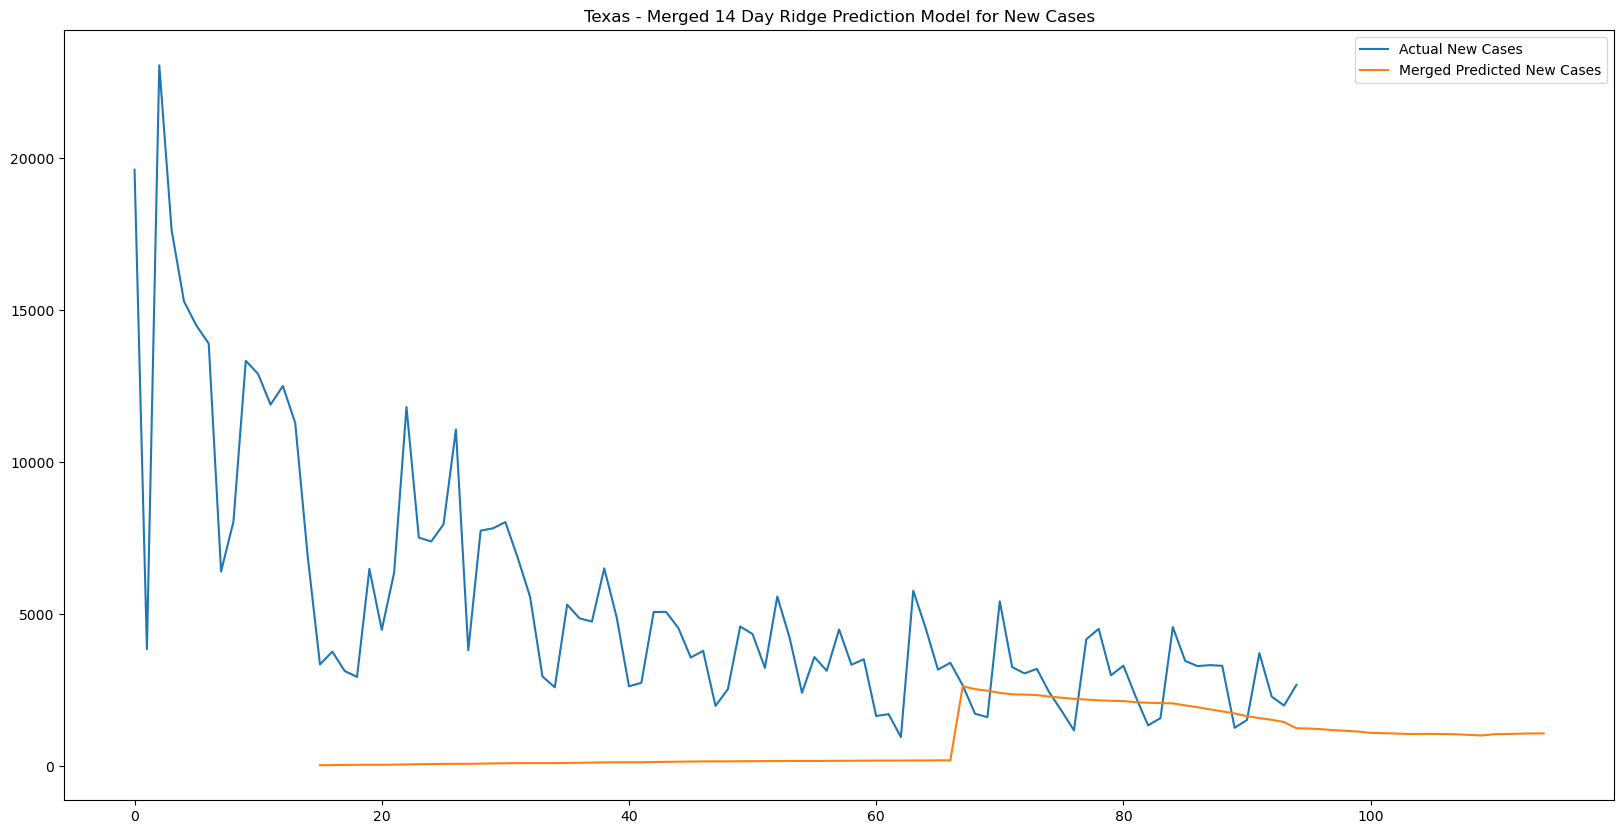

In [39]:

# addedTX = np.insert(linPred14R_TX,0,orig_tx[14],axis=0)
addedTX = np.insert(linPred14R_TX,0,None,axis=0)
for i in range(0,13):
    addedTX = np.insert(addedTX,0,None,axis=0)
addedTX = np.insert(addedTX,0,None,axis=0)   
plt.figure(figsize=(20, 10))
plt.plot(orig_tx,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedTX, label = "Merged Predicted New Cases")
plt.title("Texas - Merged 14 Day Ridge Prediction Model for New Cases")
plt.legend()

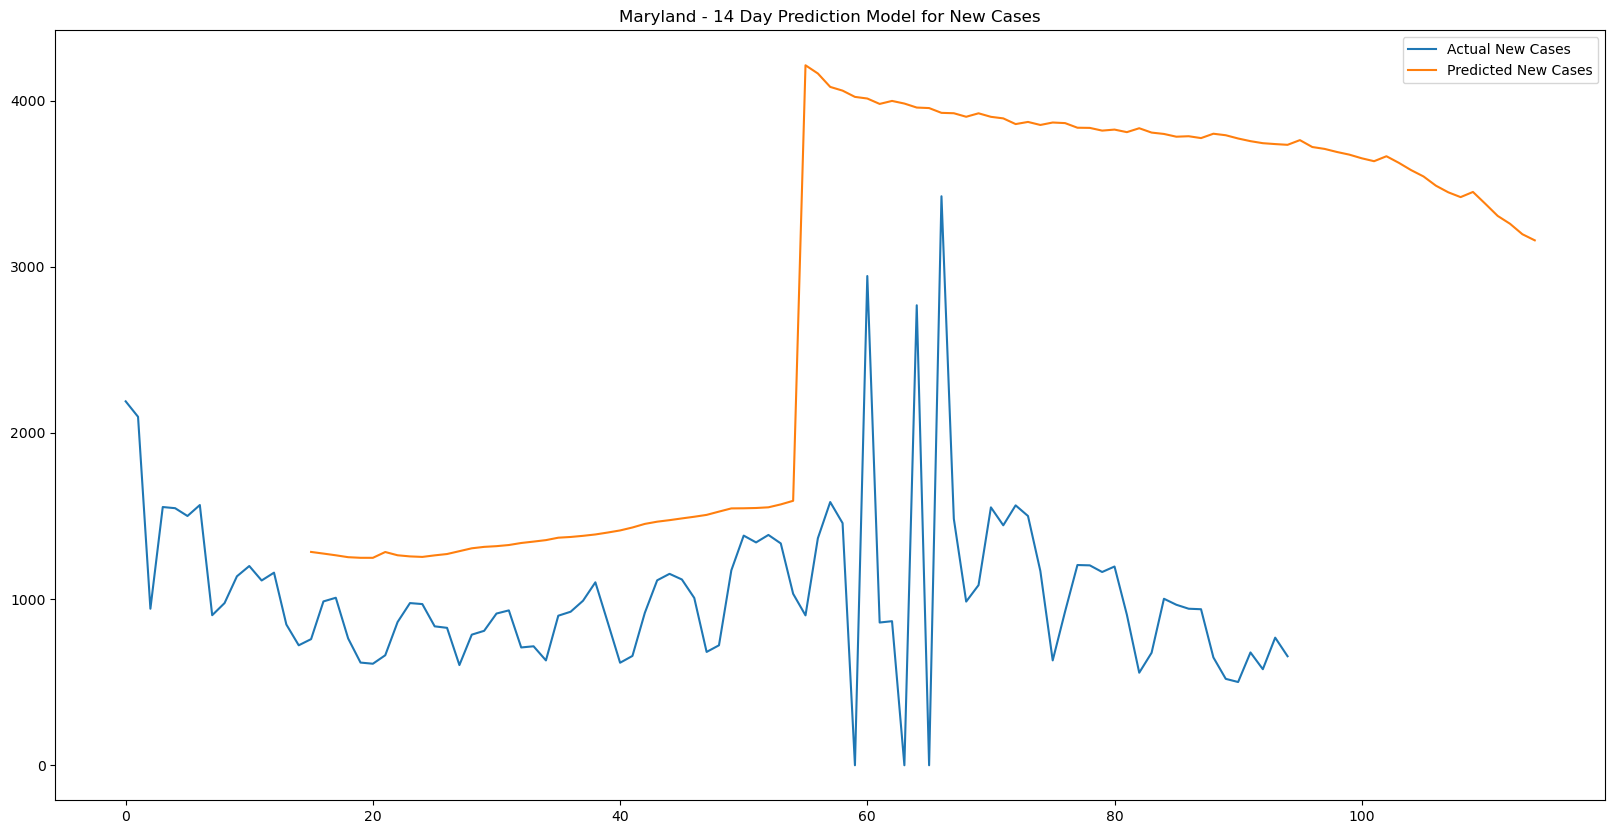

In [40]:
addedMD = np.insert(linPred14_MD,0,None,axis=0)
for i in range(0,13):
    addedMD = np.insert(addedMD,0,None,axis=0)
addedMD = np.insert(addedMD,0,orig_md[0],axis=0)   
plt.figure(figsize=(20, 10))
plt.plot(orig_md,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedMD, label = "Predicted New Cases")
plt.title("Maryland - 14 Day Prediction Model for New Cases")
plt.legend()

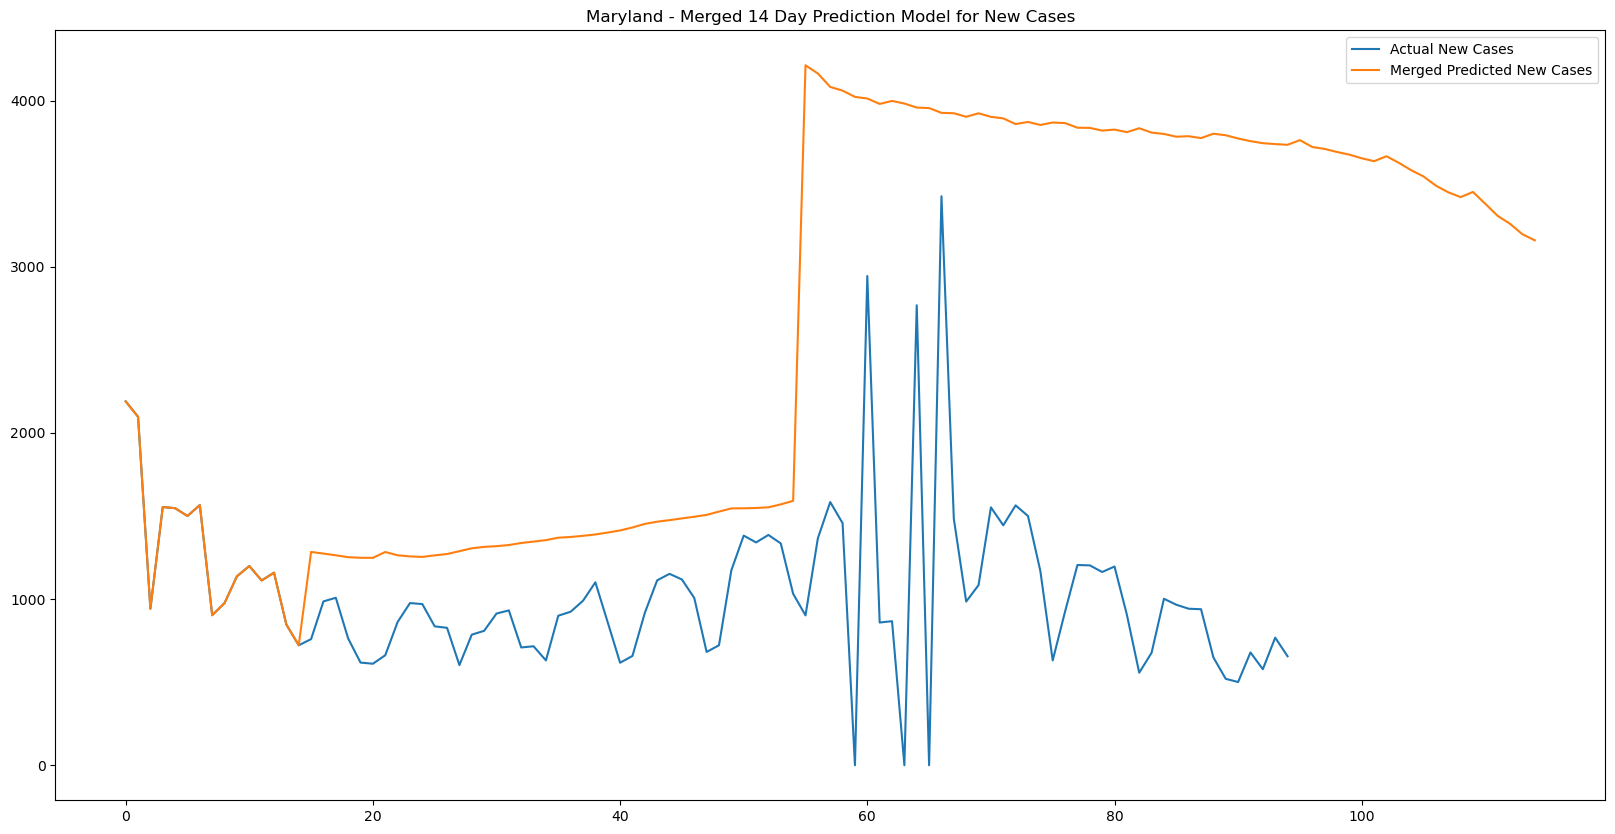

In [41]:
addedMD = np.insert(linPred14_MD,0,orig_md[14],axis=0)
for i in range(0,13):
    addedMD = np.insert(addedMD,0,orig_md[13-i],axis=0)
addedMD = np.insert(addedMD,0,orig_md[0],axis=0)   
plt.figure(figsize=(20, 10))
plt.plot(orig_md,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedMD, label = "Merged Predicted New Cases")
plt.title("Maryland - Merged 14 Day Prediction Model for New Cases")
plt.legend()

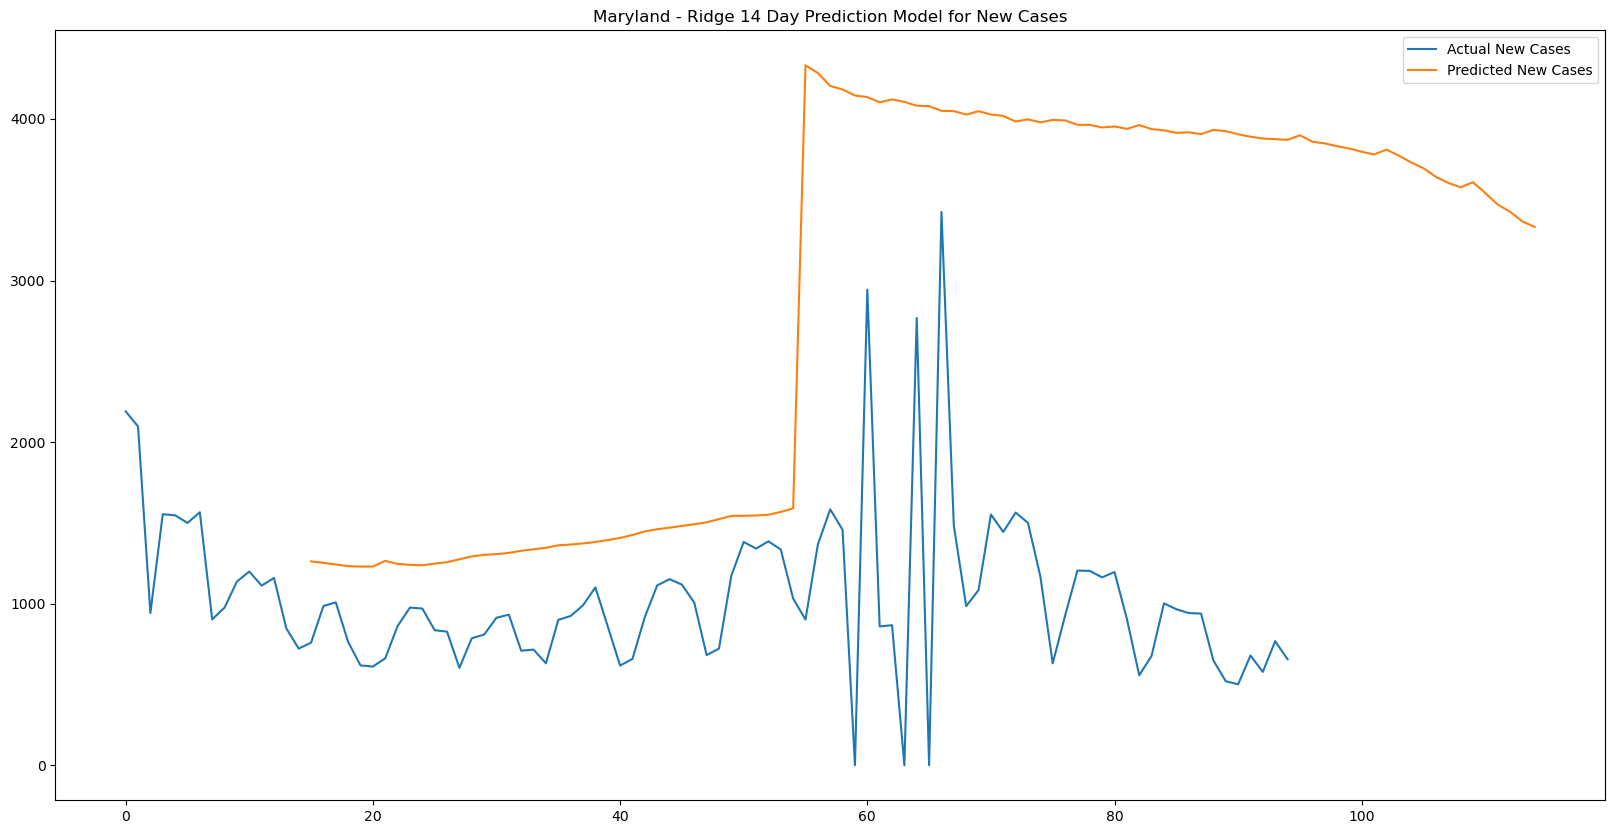

In [42]:
addedMD = np.insert(linPred14R_MD,0,None,axis=0)
for i in range(0,13):
    addedMD = np.insert(addedMD,0,None,axis=0)
addedMD = np.insert(addedMD,0,orig_md[0],axis=0)   
plt.figure(figsize=(20, 10))
plt.plot(orig_md,label="Actual New Cases")
# plt.plot(linPred14_FL, label = "Predicted - 14 days ")
plt.plot(addedMD, label = "Predicted New Cases")
plt.title("Maryland - Ridge 14 Day Prediction Model for New Cases")
plt.legend()

In [50]:
%run clean_state_data.py United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_May13.csv

['submission_date', 'state', 'tot_cases', 'conf_cases', 'prob_cases', 'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death', 'new_death', 'pnew_death', 'created_at', 'consent_cases', 'consent_deaths']
<class 'csv.DictReader'>
